In [82]:
import pandas as pd
import numpy as np

# plotting
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

# machine learning models
from prophet import Prophet
from prophet.utilities import regressor_coefficients
from sklearn.metrics import mean_absolute_error as mae

In [2]:
# read df and clear
df = pd.read_csv(r"C:\Users\User\Downloads\Live_20210128.csv")

In [3]:
df

status_id status_type status_published  num_reactions  num_comments  \
0             1       video   4/22/2018 6:00            529           512   
1             2       photo  4/21/2018 22:45            150             0   
2             3       video   4/21/2018 6:17            227           236   
3             4       photo   4/21/2018 2:29            111             0   
4             5       photo   4/18/2018 3:22            213             0   
...         ...         ...              ...            ...           ...   
7045       7046       photo   9/24/2016 2:58             89             0   
7046       7047       photo  9/23/2016 11:19             16             0   
7047       7048       photo  9/21/2016 23:03              2             0   
7048       7049       photo   9/20/2016 0:43            351            12   
7049       7050       photo  9/10/2016 10:30             17             0   

      num_shares  num_likes  num_loves  num_wows  num_hahas  num_sads  \
0            262        432         92         3          1         1   
1              0        150          0         0          0         0   
2             57        204         21         1          1         0   
3              0        111          0         0          0         0   
4              0        204          9         0          0         0   
...          ...        ...        ...       ...        ...       ...   
7045           0         89          0         0          0         0   
7046           0         14          1         0          1         0   
7047           0          1          1         0          0         0   
7048          22        349          2         0          0         0   
7049           0         17          0         0          0         0   

      num_angrys  Column1  Column2  Column3  Column4  
0              0      NaN      NaN      NaN      NaN  
1              0      NaN      NaN      NaN      NaN  
2              0      NaN      NaN      NaN      NaN  
3              0      NaN      NaN      NaN      NaN  
4              0      NaN      NaN      NaN      NaN  
...          ...      ...      ...      ...      ...  
7045           0      NaN      NaN      NaN      NaN  
7046           0      NaN      NaN      NaN      NaN  
7047           0      NaN      NaN      NaN      NaN  
7048           0      NaN      NaN      NaN      NaN  
7049           0      NaN      NaN      NaN      NaN  

[7050 rows x 16 columns]

#### Our dataframe looks good. We see that it has 7050 observations and 16 variables. The last 4 columns are empty. Let's drop them.

In [4]:
df = df.drop(["Column1", "Column2", "Column3", "Column4"], axis="columns")

In [5]:
df[df.isnull().any(axis=1)].head()

Empty DataFrame
Columns: [status_id, status_type, status_published, num_reactions, num_comments, num_shares, num_likes, num_loves, num_wows, num_hahas, num_sads, num_angrys]
Index: []

#### There are no missing values.

In [6]:
# analysing the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7050 entries, 0 to 7049
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   status_id         7050 non-null   int64 
 1   status_type       7050 non-null   object
 2   status_published  7050 non-null   object
 3   num_reactions     7050 non-null   int64 
 4   num_comments      7050 non-null   int64 
 5   num_shares        7050 non-null   int64 
 6   num_likes         7050 non-null   int64 
 7   num_loves         7050 non-null   int64 
 8   num_wows          7050 non-null   int64 
 9   num_hahas         7050 non-null   int64 
 10  num_sads          7050 non-null   int64 
 11  num_angrys        7050 non-null   int64 
dtypes: int64(10), object(2)
memory usage: 661.1+ KB


#### We see that the status_type and status_published variables are of type "Object". We need to set them to numerical/datetime/categorical format in order to work with them. 

In [7]:
print(df["status_type"].value_counts())   # displaying all the status types that this variable contains. They are photo, video, status and link.
df["status_type"] = df["status_type"].astype("category")  # this variable is now categorical

status_type
photo     4288
video     2334
status     365
link        63
Name: count, dtype: int64


In [8]:
print(df["status_published"])  # status_published displays first the date and then the time of the publication
df["status_published"] = pd.to_datetime(df["status_published"]) # converting the values in the "status_published" to datetime objects

0        4/22/2018 6:00
1       4/21/2018 22:45
2        4/21/2018 6:17
3        4/21/2018 2:29
4        4/18/2018 3:22
             ...       
7045     9/24/2016 2:58
7046    9/23/2016 11:19
7047    9/21/2016 23:03
7048     9/20/2016 0:43
7049    9/10/2016 10:30
Name: status_published, Length: 7050, dtype: object


In [9]:
df.dtypes  #the newly assigned types of the variables

status_id                    int64
status_type               category
status_published    datetime64[ns]
num_reactions                int64
num_comments                 int64
num_shares                   int64
num_likes                    int64
num_loves                    int64
num_wows                     int64
num_hahas                    int64
num_sads                     int64
num_angrys                   int64
dtype: object

#### Now we will check for duplicates -> first checking if there are more than one of the same ID, then checking if observations have different IDs but the same information (the exact same time of publishing and so on)

In [10]:
df.nunique() #counting the number of unique values

status_id           7050
status_type            4
status_published    6913
num_reactions       1067
num_comments         993
num_shares           501
num_likes           1044
num_loves            229
num_wows              65
num_hahas             42
num_sads              24
num_angrys            14
dtype: int64

#### The status_ids are all different (all 7050), but there are more than one "status_published" at the exact same point of time (the value for "status_published" is only 6913) which is strange. We can assume that some of these observations are duplicates. We need to check if the other values for these observations are different in order to be sure whether they are duplocate.

In [11]:
df.drop("status_id", axis="columns").drop_duplicates()  

status_type    status_published  num_reactions  num_comments  num_shares  \
0          video 2018-04-22 06:00:00            529           512         262   
1          photo 2018-04-21 22:45:00            150             0           0   
2          video 2018-04-21 06:17:00            227           236          57   
3          photo 2018-04-21 02:29:00            111             0           0   
4          photo 2018-04-18 03:22:00            213             0           0   
...          ...                 ...            ...           ...         ...   
7045       photo 2016-09-24 02:58:00             89             0           0   
7046       photo 2016-09-23 11:19:00             16             0           0   
7047       photo 2016-09-21 23:03:00              2             0           0   
7048       photo 2016-09-20 00:43:00            351            12          22   
7049       photo 2016-09-10 10:30:00             17             0           0   

      num_likes  num_loves  num_wows  num_hahas  num_sads  num_angrys  
0           432         92         3          1         1           0  
1           150          0         0          0         0           0  
2           204         21         1          1         0           0  
3           111          0         0          0         0           0  
4           204          9         0          0         0           0  
...         ...        ...       ...        ...       ...         ...  
7045         89          0         0          0         0           0  
7046         14          1         0          1         0           0  
7047          1          1         0          0         0           0  
7048        349          2         0          0         0           0  
7049         17          0         0          0         0           0  

[6996 rows x 11 columns]

#### Here we dropped the variable "status_id". The function drop_duplicates drops all observations from the resulting data frame that are the same.

In [12]:
df = df[df.index.isin(df.drop("status_id", axis="columns").drop_duplicates().index)] # saving the dataframe without duplicates

# .index accesses the index of the resulting dataframe obtained after dropping the "status_id" column and removing duplicates
# df.index.isin(...): This creates a boolean mask by checking if each index value in the original df is present in the index of the newly obtained dataframe. This results in a Series of True and False values.
# The boolean mask is used to filter the original df. It keeps only the rows where the index is present in the index of the newly obtained dataframe

In [13]:
df 

status_id status_type    status_published  num_reactions  num_comments  \
0             1       video 2018-04-22 06:00:00            529           512   
1             2       photo 2018-04-21 22:45:00            150             0   
2             3       video 2018-04-21 06:17:00            227           236   
3             4       photo 2018-04-21 02:29:00            111             0   
4             5       photo 2018-04-18 03:22:00            213             0   
...         ...         ...                 ...            ...           ...   
7045       7046       photo 2016-09-24 02:58:00             89             0   
7046       7047       photo 2016-09-23 11:19:00             16             0   
7047       7048       photo 2016-09-21 23:03:00              2             0   
7048       7049       photo 2016-09-20 00:43:00            351            12   
7049       7050       photo 2016-09-10 10:30:00             17             0   

      num_shares  num_likes  num_loves  num_wows  num_hahas  num_sads  \
0            262        432         92         3          1         1   
1              0        150          0         0          0         0   
2             57        204         21         1          1         0   
3              0        111          0         0          0         0   
4              0        204          9         0          0         0   
...          ...        ...        ...       ...        ...       ...   
7045           0         89          0         0          0         0   
7046           0         14          1         0          1         0   
7047           0          1          1         0          0         0   
7048          22        349          2         0          0         0   
7049           0         17          0         0          0         0   

      num_angrys  
0              0  
1              0  
2              0  
3              0  
4              0  
...          ...  
7045           0  
7046           0  
7047           0  
7048           0  
7049           0  

[6996 rows x 12 columns]

#### After cleaning, our data has 6996 observations and 12 variables.

### Let's look at the correlation between numeric variables.

In [14]:
correlation_matrix = df.select_dtypes(["number"]).corr()
print(correlation_matrix)

               status_id  num_reactions  num_comments  num_shares  num_likes  \
status_id       1.000000      -0.207802      0.186255    0.210293  -0.230868   
num_reactions  -0.207802       1.000000      0.156146    0.259594   0.994671   
num_comments    0.186255       0.156146      1.000000    0.640524   0.105888   
num_shares      0.210293       0.259594      0.640524    1.000000   0.179614   
num_likes      -0.230868       0.994671      0.105888    0.179614   1.000000   
num_loves       0.157392       0.310600      0.521304    0.820277   0.212665   
num_wows        0.054703       0.261678      0.163493    0.409794   0.199996   
num_hahas       0.116399       0.179630      0.325051    0.399851   0.123100   
num_sads        0.036681       0.082065      0.257533    0.218613   0.057080   
num_angrys      0.097134       0.136038      0.239545    0.332343   0.096249   

               num_loves  num_wows  num_hahas  num_sads  num_angrys  
status_id       0.157392  0.054703   0.116399  0.

In [15]:
exclude_variable = 'status_id'
correlation_matrix_excluded = correlation_matrix.drop(exclude_variable).drop(exclude_variable, axis=1)

<Axes: >

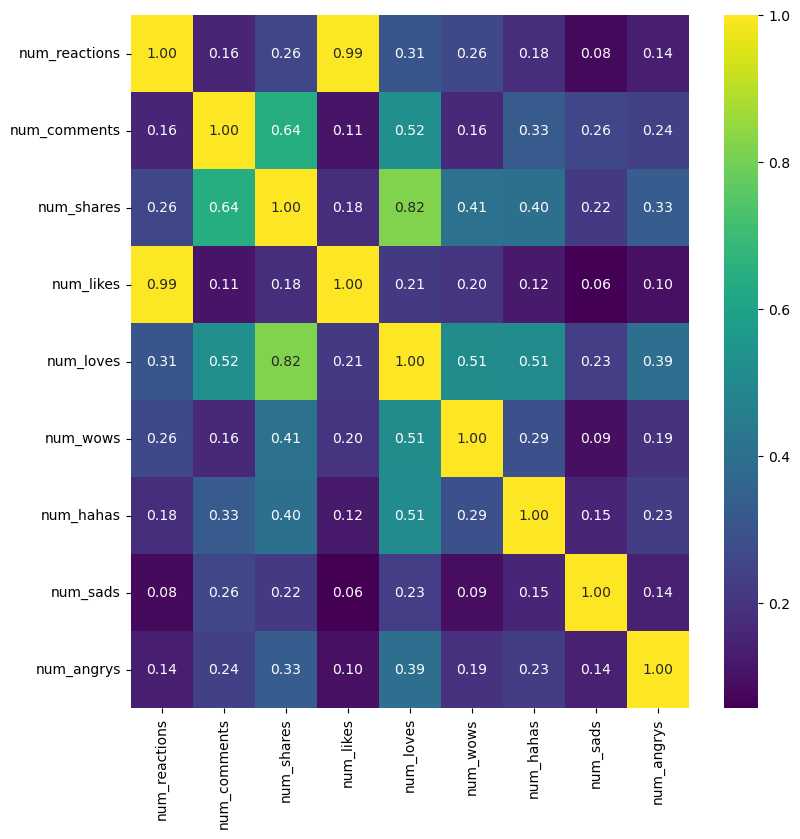

In [16]:
plt.figure(figsize = (9,9))
sns.heatmap(correlation_matrix_excluded, annot = True, fmt = ".2f", cmap = "viridis")

We can see that the correlation between likes and number of reactions is almost 1. This might be due to the fact that the most reactions are likes and as such almost the whole information of number of likes is contained in the number of reactions. Also the 3 variables num_comments, num_shares and num_loves correlate between each other a lot.
Now, let's look at the desriptive statistics of our data (excluding the variable status_id).

In [17]:
df_without_column = df.drop(columns=[exclude_variable])
table_without_column = df_without_column.describe().round(2)
print(table_without_column)

                    status_published  num_reactions  num_comments  num_shares  \
count                           6996        6996.00       6996.00     6996.00   
mean   2016-11-16 06:45:15.737564416         225.09        225.65       40.28   
min              2012-07-15 02:51:00           0.00          0.00        0.00   
25%              2016-03-08 02:38:30          17.00          0.00        0.00   
50%              2017-11-17 01:04:30          58.00          4.00        0.00   
75%              2018-03-06 07:14:15         216.00         22.25        4.00   
max              2018-06-13 01:12:00        4710.00      20990.00     3424.00   
std                              NaN         452.95        892.92      132.07   

       num_likes  num_loves  num_wows  num_hahas  num_sads  num_angrys  
count    6996.00    6996.00   6996.00    6996.00   6996.00     6996.00  
mean      210.04      12.76      1.25       0.70      0.23        0.11  
min         0.00       0.00      0.00       0.00   

We will now dive deeper the relationship between time and the other variables.

In [18]:
df = df.sort_values("status_published")   # sorts observations by the column status_published
# will not affect our model

In [19]:
fig = go.Figure()
fig.add_trace(go.Scatter(
   name="Number of Reactions",
   mode="lines", x=df["status_published"], y=df["num_reactions"], line={'width': 6}
))

fig.add_trace(go.Scatter(
   name="Number of Likes",
   mode="lines", x=df["status_published"], y=df["num_likes"], stackgroup = 'one'
))

fig.add_trace(go.Scatter(
   name="Number of Loves",
   mode="lines", x=df["status_published"], y=df["num_loves"], stackgroup = 'one'
))

fig.add_trace(go.Scatter(
   name="Number of Wows",
   mode="lines", x=df["status_published"], y=df["num_wows"], stackgroup = 'one'
))

fig.add_trace(go.Scatter(
   name="Number of Hahas",
   mode="lines", x=df["status_published"], y=df["num_hahas"], stackgroup = 'one'
))

fig.add_trace(go.Scatter(
   name="Number of Sads",
   mode="lines", x=df["status_published"], y=df["num_sads"], stackgroup = 'one'
))

fig.add_trace(go.Scatter(
   name="Number of Angrys",
   mode="lines", x=df["status_published"], y=df["num_angrys"], stackgroup = 'one'
))

fig.add_trace(go.Scatter(
   name="Number of Comments",
   mode="lines", x=df["status_published"], y=df["num_comments"], stackgroup = 'one'
))

fig.update_xaxes(rangeslider_visible=True,
                    rangeselector=dict(
       buttons=list([
           dict(count=7, label="1w", step="day", stepmode="backward"),
           dict(count=1, label="1m", step="month", stepmode="backward"),
           dict(count=6, label="6m", step="month", stepmode="backward"),
           dict(count=1, label="1y", step="year", stepmode="backward"),
           dict(step="all")
       ]))
)

fig.show()

### We can see that the most reactions are in the period after 2016. This is because Facebook rolled them out on 24.02.2016. That also explains the high correlation between likes and number of reactions

#### Let's see if there is any circle dependency in the datetime of likes

## TO DO: Analysis of the other seasonalities

In [20]:
df_plot = df.copy()
df_plot["hour_dt"] = df["status_published"].dt.hour + 1
df_plot = df_plot.groupby(["hour_dt", "status_type"]).num_reactions.mean().reset_index()
df_plot = df_plot.sort_values(["status_type", "hour_dt"])
df_plot["hour_dt"] = df_plot["hour_dt"].astype("string")
fig = go.Figure()
# fig.add_trace(go.Scatterpolar(
#        r = df_plot["num_reactions"],
#        theta = df_plot["hour_dt"],
#        mode = 'lines',
#    ))

fig = px.line_polar(df_plot, r="num_reactions", theta="hour_dt", line_close=True, color="status_type", title = "Average Number of Reactions by Status Type grouped by hour")#
                   #color_discrete_sequence=px.colors.sequential.Plasma_r,)

fig.update_traces(fill='toself')

fig.show()

C:\Users\User\AppData\Local\Temp\ipykernel_21064\4061649688.py:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

d:\anaconda\envs\probe\lib\site-packages\plotly\express\_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [21]:
df_plot = df.copy()
df_plot["hour_dt"] = df["status_published"].dt.day_of_week + 1
df_plot = df_plot.groupby(["hour_dt", "status_type"]).num_reactions.mean().reset_index()
df_plot = df_plot.sort_values(["status_type", "hour_dt"])
df_plot["hour_dt"] = df_plot["hour_dt"].astype("string")
fig = go.Figure()
# fig.add_trace(go.Scatterpolar(
#        r = df_plot["num_reactions"],
#        theta = df_plot["hour_dt"],
#        mode = 'lines',
#    ))

fig = px.line_polar(df_plot, r="num_reactions", theta="hour_dt", line_close=True, color="status_type", title = "Average Number of Reactions by Status Type grouped by day of week")#
                   #color_discrete_sequence=px.colors.sequential.Plasma_r,)

fig.update_traces(fill='toself')

fig.show()

C:\Users\User\AppData\Local\Temp\ipykernel_21064\792419646.py:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

d:\anaconda\envs\probe\lib\site-packages\plotly\express\_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [22]:
df_plot = df.copy()
df_plot["hour_dt"] = df["status_published"].dt.month
df_plot = df_plot.groupby(["hour_dt", "status_type"]).num_reactions.mean().reset_index()
df_plot = df_plot.sort_values(["status_type", "hour_dt"])
df_plot["hour_dt"] = df_plot["hour_dt"].astype("string")
fig = go.Figure()
# fig.add_trace(go.Scatterpolar(
#        r = df_plot["num_reactions"],
#        theta = df_plot["hour_dt"],
#        mode = 'lines',
#    ))

fig = px.line_polar(df_plot, r="num_reactions", theta="hour_dt", line_close=True, color="status_type", title = "Average Number of Reactions by Status Type grouped by month")#
                   #color_discrete_sequence=px.colors.sequential.Plasma_r,)

fig.update_traces(fill='toself')

fig.show()

C:\Users\User\AppData\Local\Temp\ipykernel_21064\462296791.py:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

d:\anaconda\envs\probe\lib\site-packages\plotly\express\_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [23]:
# original
dict_replace = {"photo": 1, "status" : 2, "video" : 3, "link" : 4}

fig = go.Figure(data=
   go.Parcoords(
       line = dict(color = df['status_type'].replace(dict_replace), showscale = True,
                   colorscale = [[0,'purple'],[0.33,'lightseagreen'],[0.66,'gold'],[1,'blue']]),
       dimensions = list([
           dict(label = 'Number of Reactions', values = df['num_reactions']),
          dict(label = 'Number of Comments', values = df['num_comments']),
           dict(label = 'Number of Shares', values = df['num_shares'])
       ])
   )
)

fig.update_layout(
   plot_bgcolor = 'white',
   paper_bgcolor = 'white'
)

fig.update_layout(
   title=dict(text="1 is Photo, 2 is Status, 3 is Video and 4 is link", font=dict(size=20), yref='paper')
)

fig.show()

In [24]:
# Filter the DataFrame for "photo" status type
df_photo = df[df['status_type'] == 'photo']

dict_replace = {"photo": 1, "status": 2, "video": 3, "link": 4}

fig = go.Figure(data=go.Parcoords(
    line=dict(
        color=df_photo['status_type'].replace(dict_replace),
        colorscale=[[0, 'midnightblue'], [1, 'midnightblue']]
    ),
    dimensions=list([
        dict(label='Number of Reactions', values=df_photo['num_reactions']),
        dict(label='Number of Comments', values=df_photo['num_comments']),
        dict(label='Number of Shares', values=df_photo['num_shares'])
    ])
))

fig.update_layout(
    title='Photos',
    plot_bgcolor='white',
    paper_bgcolor='white'
)


In [25]:
# Filter the DataFrame for "status" status type
df_status = df[df['status_type'] == 'status']

dict_replace = {"photo": 1, "status": 2, "video": 3, "link": 4}

fig = go.Figure(data=go.Parcoords(
    line=dict(
        color=df_status['status_type'].replace(dict_replace),
        colorscale=[[0, 'lightskyblue'], [1, 'lightskyblue']]
    ),
    dimensions=list([
        dict(label='Number of Reactions', values=df_photo['num_reactions']),
        dict(label='Number of Comments', values=df_photo['num_comments']),
        dict(label='Number of Shares', values=df_photo['num_shares'])
    ])
))

fig.update_layout(
    title='Statuses',
    plot_bgcolor='white',
    paper_bgcolor='white'
)



In [26]:
# Filter the DataFrame for "video" status type
df_video = df[df['status_type'] == 'video']

dict_replace = {"photo": 1, "status": 2, "video": 3, "link": 4}

fig = go.Figure(data=go.Parcoords(
    line=dict(
        color=df_video['status_type'].replace(dict_replace),
        colorscale=[[0, 'lightseagreen'], [1, 'lightseagreen']]
    ),
    dimensions=list([
        dict(label='Number of Reactions', values=df_photo['num_reactions']),
        dict(label='Number of Comments', values=df_photo['num_comments']),
        dict(label='Number of Shares', values=df_photo['num_shares'])
    ])
))

fig.update_layout(
    title='Videos',
    plot_bgcolor='white',
    paper_bgcolor='white'
)

In [27]:
# Filter the DataFrame for "link" status type
df_link = df[df['status_type'] == 'link']

dict_replace = {"photo": 1, "status": 2, "video": 3, "link": 4}

fig = go.Figure(data=go.Parcoords(
    line=dict(
        color=df_link['status_type'].replace(dict_replace),
        colorscale=[[0, 'rebeccapurple'], [1, 'rebeccapurple']]
    ),
    dimensions=list([
        dict(label='Number of Reactions', values=df_photo['num_reactions']),
        dict(label='Number of Comments', values=df_photo['num_comments']),
        dict(label='Number of Shares', values=df_photo['num_shares'])
    ])
))

fig.update_layout(
    title='Links',
    plot_bgcolor='white',
    paper_bgcolor='white'
)

#### remove the outlier in photos 
Do it for every status type

C:\Users\User\AppData\Local\Temp\ipykernel_21064\3027576823.py:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




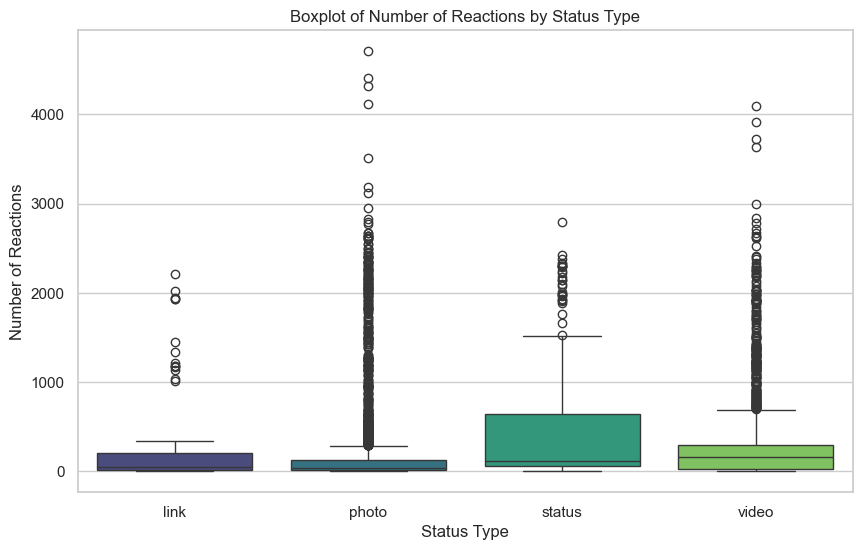

In [28]:
# Set the style of seaborn for better aesthetics
sns.set(style="whitegrid")

# Create a boxplot
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
sns.boxplot(x='status_type', y='num_reactions', data=df, palette='viridis')

# Set plot labels and title
plt.xlabel('Status Type')
plt.ylabel('Number of Reactions')
plt.title('Boxplot of Number of Reactions by Status Type')

# Show the plot
plt.show()

## Preparation for the model

### remove the reactions columns that came after 2016 because they will throw off the model, also the number of likes correlate a lot with the number of reactions so they will also be dropped. The status ID will also be dropped because it is just an integer.

In [29]:
df_filtered = df.drop(["num_loves", "num_likes", "num_wows", "num_hahas", "num_sads", "num_angrys", "status_id"], axis = "columns")

#### One hot encoding for the status type

In [30]:
df_filtered = pd.get_dummies(df_filtered, columns = ["status_type"], dtype = "int")

In [31]:
df_filtered

status_published  num_reactions  num_comments  num_shares  \
2634 2012-07-15 02:51:00             15             3           0   
2633 2012-07-15 02:58:00             14             7           0   
2632 2012-07-15 03:32:00             14             1           0   
2631 2012-07-15 03:42:00             12             3           0   
2630 2012-07-15 03:54:00             19            17           3   
...                  ...            ...           ...         ...   
4734 2018-06-12 22:55:00              9             0           1   
4733 2018-06-12 23:15:00              2             4           0   
4732 2018-06-13 00:58:00             97           177         210   
4731 2018-06-13 00:59:00             27             0          18   
4730 2018-06-13 01:12:00              2             0           0   

      status_type_link  status_type_photo  status_type_status  \
2634                 0                  1                   0   
2633                 0                  1                   0   
2632                 0                  1                   0   
2631                 0                  1                   0   
2630                 0                  1                   0   
...                ...                ...                 ...   
4734                 0                  1                   0   
4733                 0                  1                   0   
4732                 0                  0                   0   
4731                 0                  0                   0   
4730                 0                  1                   0   

      status_type_video  
2634                  0  
2633                  0  
2632                  0  
2631                  0  
2630                  0  
...                 ...  
4734                  0  
4733                  0  
4732                  1  
4731                  1  
4730                  0  

[6996 rows x 8 columns]

In [32]:
df_prophet = df_filtered.rename({"status_published" : "ds", "num_reactions" : "y"}, axis = "columns")[["ds", "y", "num_shares", "status_type_link", "status_type_photo", "status_type_status", "status_type_video"]]

In [33]:
df_train = df_prophet[df_prophet.ds <= pd.to_datetime("01.03.2018")]
df_test = df_prophet[df_prophet.ds > pd.to_datetime("01.03.2018")]

In [87]:
help(Prophet)

Help on class Prophet in module prophet.forecaster:

class Prophet(builtins.object)
 |  Prophet(growth='linear', changepoints=None, n_changepoints=25, changepoint_range=0.8, yearly_seasonality='auto', weekly_seasonality='auto', daily_seasonality='auto', holidays=None, seasonality_mode='additive', seasonality_prior_scale=10.0, holidays_prior_scale=10.0, changepoint_prior_scale=0.05, mcmc_samples=0, interval_width=0.8, uncertainty_samples=1000, stan_backend=None)
 |  
 |  Prophet forecaster.
 |  
 |  Parameters
 |  ----------
 |  growth: String 'linear', 'logistic' or 'flat' to specify a linear, logistic or
 |      flat trend.
 |  changepoints: List of dates at which to include potential changepoints. If
 |      not specified, potential changepoints are selected automatically.
 |  n_changepoints: Number of potential changepoints to include. Not used
 |      if input `changepoints` is supplied. If `changepoints` is not supplied,
 |      then n_changepoints potential changepoints are selec

In [111]:
# make the model and train it on the train data
m = Prophet()
m.add_regressor("num_shares")
m.add_regressor("status_type_link")
m.add_regressor("status_type_photo")
m.add_regressor("status_type_status")
m.add_regressor("status_type_video")
m.fit(df_train)

15:47:14 - cmdstanpy - INFO - Chain [1] start processing
15:47:15 - cmdstanpy - INFO - Chain [1] done processing


In [112]:
regressor_coefficients(m)

regressor regressor_mode     center  coef_lower       coef  \
0          num_shares       additive  22.178754    0.828753   0.828753   
1    status_type_link       additive   0.000000  -90.671268 -90.671268   
2   status_type_photo       additive   0.000000   29.498589  29.498589   
3  status_type_status       additive   0.000000   -2.026873  -2.026873   
4   status_type_video       additive   0.000000   45.574619  45.574619   

   coef_upper  
0    0.828753  
1  -90.671268  
2   29.498589  
3   -2.026873  
4   45.574619

In [113]:
# make the datasets for plotting the results
forecast = m.predict(df_test.drop("y", axis = "columns"))
forecast2 = m.predict(pd.merge(m.make_future_dataframe(periods=0), df_prophet).drop("y", axis = "columns"))
test_points = pd.merge(forecast, df_test, on = "ds")
train_points = pd.merge(forecast2, df_train, on = "ds")

# remove everything below 0
for col in ['yhat', 'yhat_lower', 'yhat_upper']:
    test_points[col] = test_points[col].clip(lower=0.0)
for col in ['yhat', 'yhat_lower', 'yhat_upper']:
    train_points[col] = train_points[col].clip(lower=0.0)

Text(0.5, 1.0, 'Prediction of Number of Reactions')

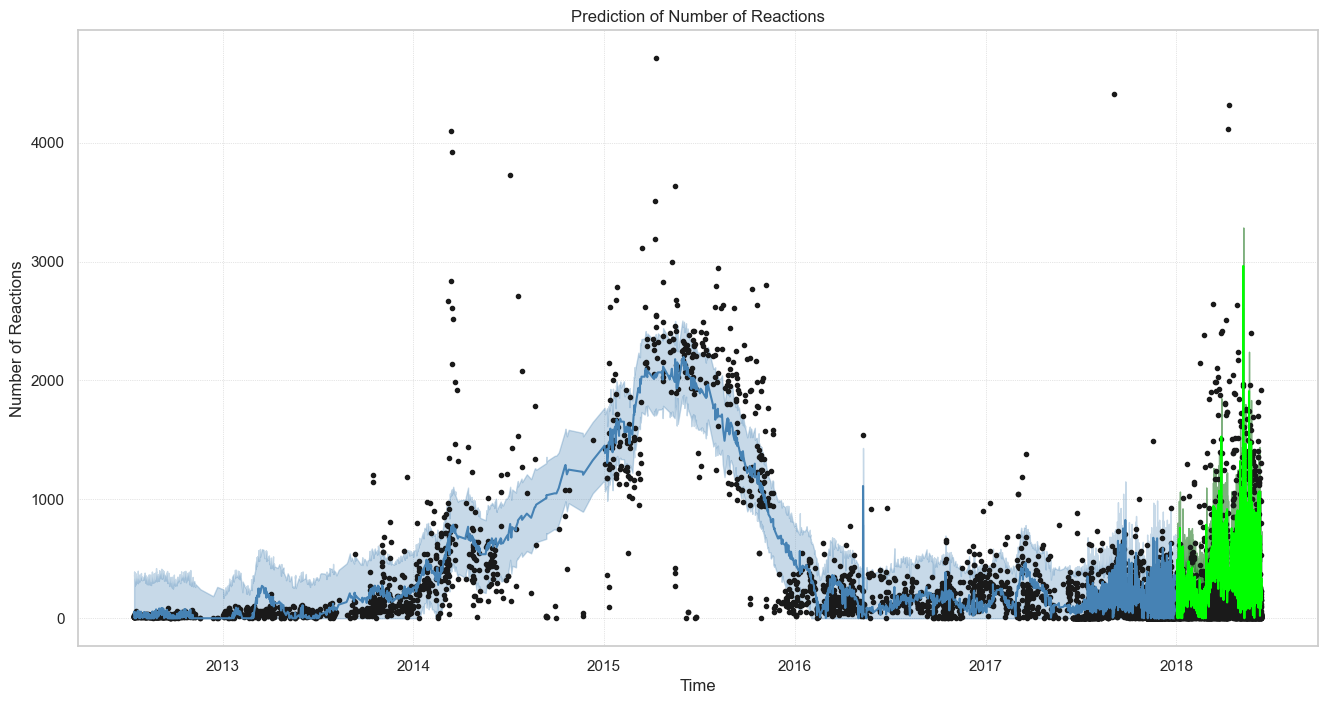

In [114]:
f, ax = plt.subplots(figsize=(16, 8))
ax.plot(train_points.ds, train_points.y, 'ko', markersize=3)
ax.plot(train_points.ds, train_points.yhat, color='steelblue', lw=1.5)
ax.fill_between(train_points.ds, train_points.yhat_lower, train_points.yhat_upper, color='steelblue', alpha=0.3)
ax.plot(test_points.ds, test_points.y, 'ko', markersize=3)
ax.plot(test_points.ds, test_points.yhat, color='lime', lw=1.5)
ax.fill_between(test_points.ds, test_points.yhat_lower, test_points.yhat_upper, color='darkgreen', alpha=0.5)
ax.grid(ls=':', lw=0.5)
ax.set_xlabel("Time")
ax.set_ylabel("Number of Reactions")
ax.set_title("Prediction of Number of Reactions")

d:\anaconda\envs\probe\lib\site-packages\prophet\plot.py:226: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

d:\anaconda\envs\probe\lib\site-packages\prophet\plot.py:395: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

d:\anaconda\envs\probe\lib\site-packages\prophet\plot.py:399: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

d:\anaconda\envs\probe\lib\site-packages\prophet\plot.py:349: FutureWarning:

The beh

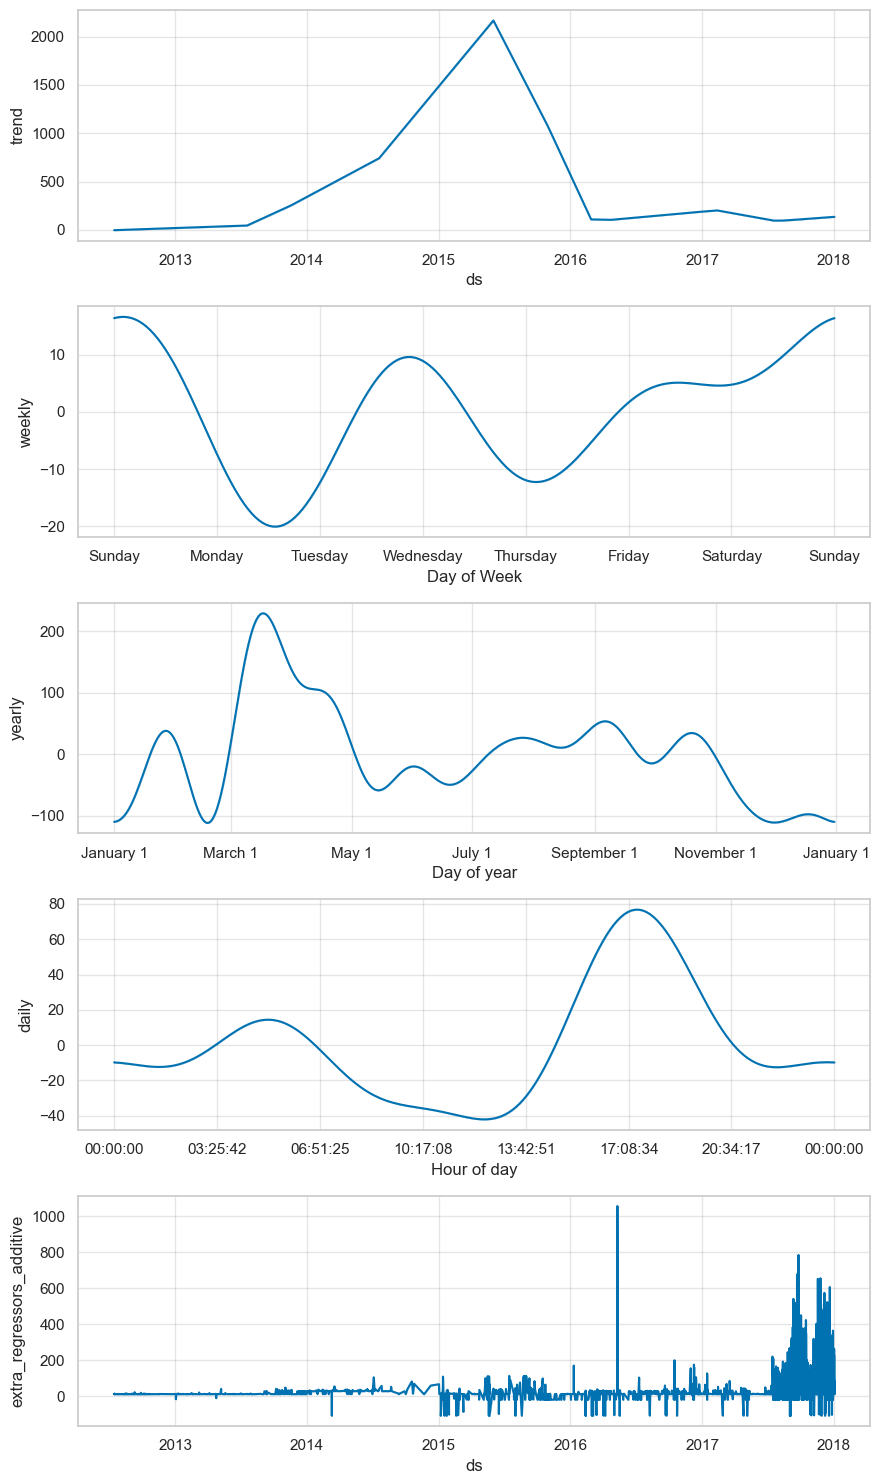

In [115]:
f = m.plot_components(forecast2)

In [116]:
mae(test_points.y, test_points.yhat)

208.55106595611574

In [117]:
mae(train_points.y, train_points.yhat)

117.9499622503269

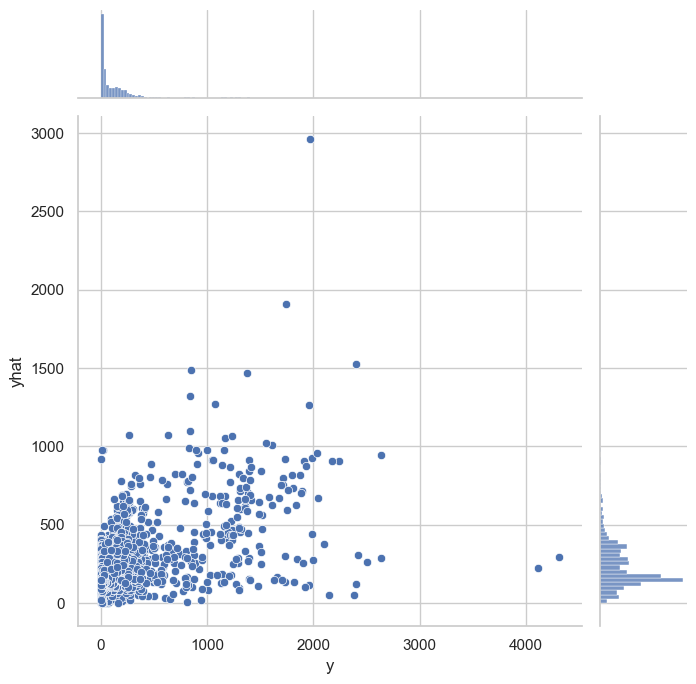

In [118]:
g = sns.jointplot(x="y", y="yhat", data=test_points, height=7)

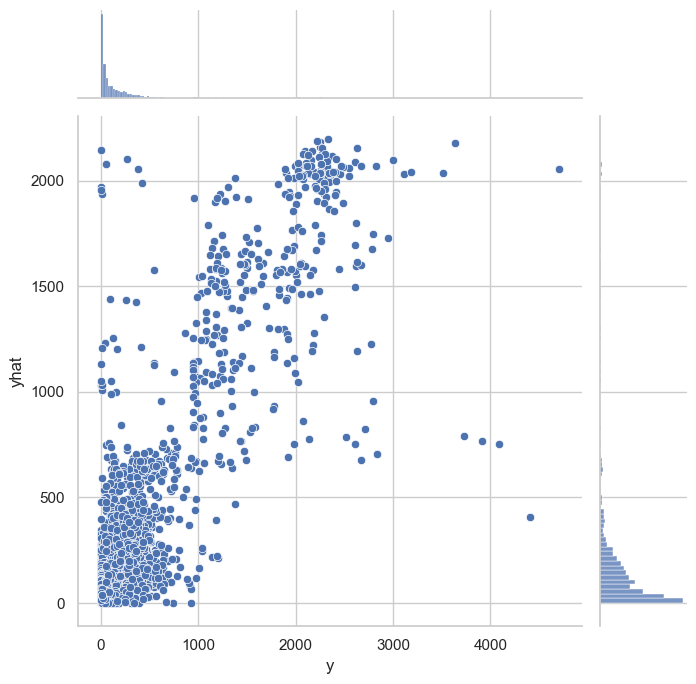

In [119]:
g = sns.jointplot(x="y", y="yhat", data=train_points, height=7)